In [4]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
from torch.autograd import Variable
# Training data is 11 points in [0,1] inclusive regularly spaced
train_x = Variable(torch.linspace(0, 1, 11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

from torch import optim
from gpytorch.kernels import RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable
from scipy.stats import norm
from scipy.optimize import minimize

In [6]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # Our mean function is constant in the interval [-1,1]
        self.mean_module = ConstantMean(constant_bounds=(-1, 1))
        # We use the RBF kernel as a universal approximator
        self.covar_module = RBFKernel(log_lengthscale_bounds=(-5, 5))
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # Return moddl output as GaussianRandomVariable
        return GaussianRandomVariable(mean_x, covar_x)

In [158]:
#Adaptation of acquisition maximization from Python BayesOpt implementation found at
#https://github.com/fmfn/BayesianOptimization

def acq_max(ac, gp, y_max, bounds, random_state, n_warmup=1000, n_iter=250):
    """
    A function to find the maximum of the acquisition function
    It uses a combination of random sampling (cheap) and the 'L-BFGS-B'
    optimization method. First by sampling `n_warmup` (1e5) points at random,
    and then running L-BFGS-B from `n_iter` (250) random starting points.
    Parameters
    ----------
    :param ac:
        The acquisition function object that return its point-wise value.
    :param gp:
        A gaussian process fitted to the relevant data.
    :param y_max:
        The current maximum known value of the target function.
    :param bounds:
        The variables bounds to limit the search of the acq max.
    :param random_state:
        instance of np.RandomState random number generator
    :param n_warmup:
        number of times to randomly sample the aquisition function
    :param n_iter:
        number of times to run scipy.minimize
    Returns
    -------
    :return: x_max, The arg max of the acquisition function.
    """
    
    # Warm up with random points
    x_tries = Variable(torch.linspace(bounds[0][0], bounds[0][1], n_warmup))
    
    ys = ac(x_tries, gp, y_max, xi=0.2).data.numpy()
    x_max = x_tries.data.numpy()[ys.argmax()]
    max_acq = float(ys.max())

    # Explore the parameter space more throughly
    x_seeds = Variable(torch.linspace(bounds[0][0], bounds[0][1], n_iter))
    
    for x_try in x_seeds:

        # Find the minimum of minus the acquisition function
        res = minimize(lambda x: -ac(Variable(torch.from_numpy(x).float()), gp, y_max, xi=0.2),
                       x_try,
                       bounds=bounds,
                       method="L-BFGS-B")

        # See if success
        if not res.success:
            continue
           
        # Store it if better than previous minimum(maximum).
        if max_acq is None or float((-res.fun[0]).gt(max_acq)):
            x_max = res.x
            max_acq = float(-res.fun[0])

    # Clip output to make sure it lies within the bounds. Due to floating
    # point technicalities this is not always the case.
    return np.clip(x_max, bounds[0][0], bounds[0][1])

In [159]:
class Bayes_opt:
    
    def __init__(self, func, step_num):
        
        self.step_num = step_num
        self.sample_pts = Variable(torch.zeros(step_num))     
        self.sample_vals = Variable(torch.zeros(step_num))       
        self.opt_val = -float("inf")       
        self.opt_soln = None       
        self.obj_func = func
        self.model_GP = None
        
        
    def _ei(self, x, gp, y_max, xi):
 
        predict_pt = gp(x)
        mean = predict_pt.mean()
        std = torch.sqrt(predict_pt.var())
        z = (mean - y_max - xi)/std
    
        return (
            (mean - y_max - xi) * Variable(torch.from_numpy(norm.cdf(z.data)).float()) + 
            std * Variable(torch.from_numpy(norm.pdf(z.data)).float())
            )        
    
    def _update_GP(self, train_x, train_y):
        
        likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))
        
        model = ExactGPModel(train_x.data, train_y.data, likelihood)
        model.train()
        likelihood.train()
        
        # Use the adam optimizer
        optimizer = torch.optim.Adam([
            {'params': model.parameters()},  # Includes GaussianLikelihood parameters
        ], lr=0.1)

        # "Loss" for GPs - the marginal log likelihood
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

        training_iter = 50
        for i in range(training_iter):
            # Zero gradients from previous iteration
            optimizer.zero_grad()
            # Output from model
            output = model(train_x)
            # Calc loss and backprop gradients
            loss = -mll(output, train_y)
            loss.backward()
            #print('Iter %d/%d - Loss: %.3f   log_lengthscale: %.3f   log_noise: %.3f' % (
                #i + 1, training_iter, loss.data[0],
                #model.covar_module.log_lengthscale.data[0, 0],
                #model.likelihood.log_noise.data[0]
            #))
            optimizer.step()
    
        # Put model and likelihood into eval mode
        model.eval()
        likelihood.eval()

        return model
        
        
    def optimize(self):
        
        start_pts = Variable(torch.rand(3))
        start_vals = Variable(start_pts.data.apply_(self.obj_func))
        self.opt_val = torch.min(start_vals.data)
        ind = torch.min(start_vals.data, 0)[1]
        self.opt_soln = start_pts[ind]

        self.model_GP = self._update_GP(start_pts, start_vals)
        
        print("GP initiated")
        
        for t in range(self.step_num):
            
            if t%10 == 9: print(t, ': ', self.opt_val)
            
            new_pt = acq_max(ac=self._ei, gp=self.model_GP, y_max=self.opt_val, bounds=[(0, 1)], random_state=np.random.RandomState())
            new_val = self.obj_func(new_pt)
            self.sample_pts[t] = float(new_pt)
            self.sample_vals[t] = float(new_val)
            
            if new_val > self.opt_val:
                self.opt_val = new_val 
                self.opt_soln = new_pt
                
            self.model_GP = self._update_GP(self.sample_pts[:t+1], self.sample_vals[:t+1])

In [162]:
#test _update_GP

def test_func(x): 
    return -1/(x+1)*np.cos(2*math.pi*x)

# Training data is 11 points in [0,1] inclusive regularly spaced
#train_x = Variable(torch.linspace(0, 1, 11))
train_x = Variable(torch.rand(11))
# True function is sin(2*pi*x) with Gaussian noise N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2)

test = Bayes_opt(test_func, 20)

test.optimize()



#model = test._update_GP(x_np=train_x, y_np=train_y)

GP initiated


9 :  -0.5
19 :  0.6701980146984186


NameError: name 'bayes_opt' is not defined

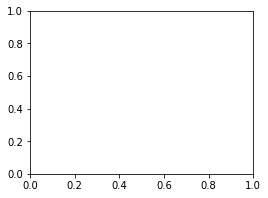

In [164]:
# Put model and likelihood into eval mode
model = test.model_GP
likelihood = GaussianLikelihood(log_noise_bounds=(-5, 5))

model.eval()
likelihood.eval()

# Initialize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points are regularly spaced along [0,1] every 0.02
test_x = Variable(torch.linspace(0, 1, 51))
# Make predictions by feeding model through likelihood
with gpytorch.fast_pred_var():
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    
    rand_var = bayes_opt.model_GP
    train_x = bayes_opt.sample_pts
    train_y = bayes_opt.sample_vals
    
    # Get upper and lower confidence bounds
    lower, upper = rand_var.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    #Plot opt soln
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)
# Plot the predictions
ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')

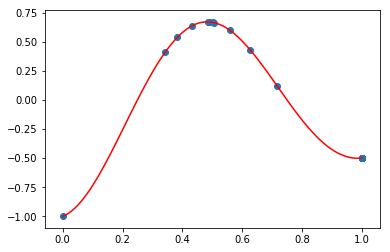

In [166]:
true_x = np.linspace(0, 1, 100)
true_y = np.vectorize(test_func)(true_x)

plt.scatter(test.sample_pts.data.numpy(), test.sample_vals.data.numpy())
plt.plot(true_x, true_y, 'r')

In [ ]:
test.sample_pts
test.sample_vals

In [44]:
y_max = Variable(torch.Tensor([0]))
xi = Variable(torch.Tensor([0.01]))
#train_x = Variable(torch.Tensor([[0, 0], [0.5, 0.5], [1, 1]]))
train_x = Variable(torch.linspace(0.1, 0.9,  3))
train_y = Variable(torch.Tensor([0, 1 , 0]))


def _ei(x, gp, y_max, xi):
    
    predict_pt = gp(x)
    mean = predict_pt.mean()
    std = torch.sqrt(predict_pt.var())
    z = (mean - y_max - xi)/std
    
    return (
            (mean - y_max - xi) * Variable(torch.from_numpy(norm.cdf(z.data)).float()) + 
            std * Variable(torch.from_numpy(norm.pdf(z.data)).float())
        )

testf = lambda x: x*(x-1)
test = Bayes_opt(testf, 10)
testGP = test._update_GP(train_x, train_y)

In [142]:
test_x = Variable(torch.Tensor([0.2, 0.4, 0.6]), requires_grad=False)

mask = test_x.gt(0.5).data
test_x[mask] = Variable(torch.Tensor([0]))

a = np.array(0)
a


array(0)

In [23]:
def get_input_param_optimizer(x):
    input_param = torch.nn.Parameter(x.data)
    optimizer = optim.LBFGS([input_param])
    return input_param, optimizer

In [169]:
test_x = Variable(torch.Tensor([0.25, 0.75]), requires_grad=True).expand(1, 2)

x, optimizer = get_input_param_optimizer(test_x)

for t in range(5):
    
    def closure():
        optimizer.zero_grad()
        loss = -_ei(x, testGP, y_max, xi)
        loss.backward()
        print(loss)
        return loss
    optimizer.step(closure)


Variable containing:
-0.7417
[torch.FloatTensor of size 1]



RuntimeError: Trying to backward through the graph a second time, but the buffers have already been freed. Specify retain_graph=True when calling backward the first time.

In [86]:
class Acq_func(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return input
    
    @staticmethod
    def backward(ctx, grad_output):
        result, = ctx.saved_variables
        return grad_output * result

In [35]:
test_x = Variable(torch.linspace(0, 1, 100))

_ei(test_x, testGP, y_max, xi)

Variable containing:
 0.3455
 0.3453
 0.3451
 0.3450
 0.3448
 0.3447
 0.3445
 0.3444
 0.3442
 0.3441
 0.3440
 0.3438
 0.3437
 0.3436
 0.3435
 0.3433
 0.3432
 0.3431
 0.3430
 0.3429
 0.3428
 0.3427
 0.3426
 0.3425
 0.3424
 0.3423
 0.3423
 0.3422
 0.3421
 0.3420
 0.3420
 0.3419
 0.3418
 0.3418
 0.3417
 0.3417
 0.3416
 0.3416
 0.3416
 0.3415
 0.3415
 0.3415
 0.3414
 0.3414
 0.3414
 0.3414
 0.3414
 0.3413
 0.3413
 0.3413
 0.3413
 0.3413
 0.3413
 0.3414
 0.3414
 0.3414
 0.3414
 0.3414
 0.3415
 0.3415
 0.3415
 0.3416
 0.3416
 0.3416
 0.3417
 0.3417
 0.3418
 0.3418
 0.3419
 0.3420
 0.3420
 0.3421
 0.3422
 0.3423
 0.3423
 0.3424
 0.3425
 0.3426
 0.3427
 0.3428
 0.3429
 0.3430
 0.3431
 0.3432
 0.3433
 0.3435
 0.3436
 0.3437
 0.3438
 0.3440
 0.3441
 0.3442
 0.3444
 0.3445
 0.3447
 0.3448
 0.3450
 0.3451
 0.3453
 0.3455
[torch.FloatTensor of size 100]